In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc,precision_recall_curve,roc_curve,confusion_matrix
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
np.random.seed(10)
random.seed(10)


## Creating larger file 

In [2]:
# big_file = pd.read_csv("../data/filtered_data_IEDB_4_tested_len_9_10_full_HLA_Multi_assay_w_binding.csv")

# # add parts column with zeros all the way 
# n = big_file.shape[0]
# empty_column = np.empty((n))
# big_file = big_file.assign(parts=empty_column)

# for file in os.listdir("../data/multi_assay_parts"):
#     print("started on new file")
#     part = int(file[-1])
#     path_to_file = os.path.join("../data/multi_assay_parts",file)
#     data = pd.read_csv(path_to_file,sep="\t",names=["peptide","label","HLA_allele"])
#     for i in range(data.shape[0]):
#         small_file_peptide = data.loc[i, "peptide"]
#         small_file_hla = data.loc[i, "HLA_allele"]
#         for j in range(big_file.shape[0]):
#             peptide = big_file.loc[j,"peptide"]
#             mhc = big_file.loc[j,"HLA_allele"]
#             if peptide == small_file_peptide and mhc == small_file_hla:                
#                 big_file.iloc[j,"parts"] = part
#                 break
  


In [3]:
# print(big_file.loc[133,"parts"])
# big_file.to_csv("../data/astrids_bigfile")

## The Network

In [4]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d

import torch.optim as optim
from sklearn.metrics import accuracy_score,recall_score,f1_score

In [5]:
def compute_conv_dim(dim_size,kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)
compute_conv_dim(34,2,0,1)

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight.data, 1)
          nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

In [6]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Denselayer
        self.L_in = Linear(in_features=529, # 528 if binding_score None, else 529
                            out_features= 1058)

        self.batchnorm1 = nn.BatchNorm1d(1058)
        self.drop_out1 = nn.Dropout(p=0.4)

        self.L_2 = Linear(in_features = 1058,
                            out_features = 750)

        self.batchnorm2 = nn.BatchNorm1d(750)
        self.drop_out2 = nn.Dropout(p=0.4)

        self.L_out = Linear(in_features = 750,
                            out_features = 2)
    
    def forward(self, peptide, HLA, binding_score=None): # x.size() = [batch, channel, height, width]

        peptide = torch.flatten(peptide,start_dim=1)

        HLA = torch.flatten(HLA,start_dim=1)

        if binding_score is None:
            combined_input = torch.cat((peptide, HLA), 1)
      
        else:
            combined_input = torch.cat((peptide, HLA,binding_score), 1)

        x = self.L_in(combined_input)
        x = relu(x)
        x = self.batchnorm1(x)
        x = self.drop_out1(x)
    
        x = self.L_2(x)
        x = relu(x)
        x = self.batchnorm2(x)
        x = self.drop_out2(x)

        x = self.L_out(x)
        x = relu(x)
        return softmax(x, dim=1)

net = Net()
net.apply(initialize_weights)
print(net)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.0001,weight_decay=1e-4)

Net(
  (L_in): Linear(in_features=529, out_features=1058, bias=True)
  (batchnorm1): BatchNorm1d(1058, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out1): Dropout(p=0.4, inplace=False)
  (L_2): Linear(in_features=1058, out_features=750, bias=True)
  (batchnorm2): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out2): Dropout(p=0.4, inplace=False)
  (L_out): Linear(in_features=750, out_features=2, bias=True)
)


In [7]:
peptide_random = np.random.normal(0,1, (10, 1, 10, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (10, 1, 34, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
binding_random = np.random.normal(0,1, (10, 1)).astype('float32')
binding_random = Variable(torch.from_numpy(binding_random))

output = net(peptide_random,HLA_random, binding_random)
output

tensor([[0.2831, 0.7169],
        [0.5000, 0.5000],
        [0.8914, 0.1086],
        [0.4491, 0.5509],
        [0.0390, 0.9610],
        [0.9495, 0.0505],
        [0.5000, 0.5000],
        [0.0621, 0.9379],
        [0.5984, 0.4016],
        [0.6699, 0.3301]], grad_fn=<SoftmaxBackward0>)

## Functions for loading data

In [8]:
# def load_training_and_validataion_dataset(path_to_partitions,training_partitions):
#     import random
#     ## Training
#     # training_partions = random.sample(range(10),train_splits)
#     #training_partitions = [9, 0, 6, 3, 4, 8, 1, 7]

#     ## Validation
#     validation_partions = [i for i in range(10) if i not in training_partitions]
#     partitions = []
#     for file in os.listdir(path_to_partitions):
#         path_to_file = os.path.join(path_to_partitions,file)
#         data = pd.read_csv(path_to_file,sep="\t",names=["peptide","label","HLA_allele"])
#         partitions.append(data)
#     training_df = pd.concat([partitions[i] for i in training_partitions])
#     validation_df = pd.concat([partitions[i] for i in validation_partions])
#     return training_df, validation_df,training_partitions,validation_partions

# def retrieve_information_from_df(data_split,entire_df):
#     immunogenicity = []
#     response = []
#     tested_subjects = []
#     positive_subjects = []
#     binding_scores = []
#     for i,row in data_split.iterrows():
#         peptide, HLA = row["peptide"], row['HLA_allele']
#         original_entry = entire_df[(entire_df['peptide']==peptide) & (entire_df['HLA_allele'] == HLA)]
#         assert len(original_entry) == 1
#         immunogenicity.append(float(original_entry['immunogenicity']))
#         response.append(original_entry['Response'].values[0])
#         tested_subjects.append(int(original_entry['tested_subjects']))
#         positive_subjects.append(int(original_entry['positive_subjects']))
#         binding_scores.append(float(original_entry['binding_score']))
#     data_split['immunogenicity'] = immunogenicity
#     data_split['response'] = response
#     data_split['test'] = tested_subjects
#     data_split['positive_subjects'] = positive_subjects
#     data_split['binding_score'] = binding_scores
#     return data_split  


def encode_peptide_aaindex(aa_seq,aaindex_PCA,row):
    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(PCs)]))
        else:
            try:
                encoded_aa_seq.append(aaindex_PCA.loc[aa].to_numpy())
            except KeyError:
                print(row)
                sys.exit(1)
    return np.array(encoded_aa_seq)

def encode_dataset(df,aaindex_PCA,HLA_dict,peptide_len,padding="right"):
    encoded_peptides = []
    encoded_labels = []
    encoded_hlas = []
    encoded_binding_scores = []
    for i,row in df.iterrows():
        peptide = row["peptide"]
        HLA = HLA_dict[row["HLA_allele"].replace(":","")]
        encoded_peptide = encode_peptide_aaindex(peptide,aaindex_PCA,row)
        binding_score = row['binding_score']


        # Adding padding
        if len(encoded_peptide) < peptide_len:
            n_added = peptide_len-len(encoded_peptide)
            if padding == "right":
                encoded_peptide = np.pad(encoded_peptide, ((0, 1), (0, 0)), 'constant')
            elif padding == "left":
                encoded_peptide = np.pad(encoded_peptide, ((1, 0), (0, 0)), 'constant')
            elif padding == "random":
                top_pad = random.choice([0,1])
                bot_pad = 1-top_pad
                encoded_peptide = np.pad(encoded_peptide, ((top_pad, bot_pad), (0, 0)), 'constant')


        encoded_HLA = encode_peptide_aaindex(HLA,aaindex_PCA,row)
        encoded_label = min(1,row["positive_subjects"])
        encoded_peptides.append(encoded_peptide)
        encoded_hlas.append(encoded_HLA)
        encoded_labels.append(encoded_label)
        encoded_binding_scores.append(binding_score)
    
    encoded_peptides = np.array(encoded_peptides).astype('float32')
    encoded_hlas = np.array(encoded_hlas).astype('float32')
    encoded_labels = np.array(encoded_labels).astype('float32')
    encoded_binding_scores = np.array(encoded_binding_scores).astype('float32')
    return encoded_peptides, encoded_hlas, encoded_binding_scores, encoded_labels


## Loading the data

In [16]:
# Loading the databases
aaindex_PCA = pd.read_csv('../data/PCA_repr_aa.csv',index_col=0)
hla_database = pd.read_csv('../data/formatted_hla2paratope_MHC_pseudo.dat', sep=' ',index_col=0)
hla_dic = hla_database.to_dict("dict")["pseudo"]

all_data = pd.read_csv("../data/filtered_data_IEDB_4_tested_len_9_10_full_HLA_Multi_assay_w_binding_w_parts.csv")
all_data = all_data.sample(frac=1, random_state=1).reset_index(drop=True)

testing = False
part_dict = {0:[0,1], 1:[2,3], 2:[4,5], 3:[6,7], 4:[8,9]}
partitions = [0,1,2,3,4,5,6,7,8,9]

batch_size = 100
lst_val_accuracies = []
lst_train_accuracies = []
lst_val_predictions = []
lst_val_labels = []
lst_val_probabilities = []

for i in range(5):
    if testing == False:

        ## The partitions to use for training, validation ##
        validation_parts = part_dict[i]
        training_parts = [j for j in range(10) if j not in validation_parts]
        print("the val and train parts")
        print(validation_parts, training_parts)

        ## The actual data frames ##
        training_df = all_data[all_data["parts"].isin(training_parts)]
        validation_df = all_data[all_data["parts"].isin(validation_parts)]

        ## Encoding the data frames ##
        print("##Encoding Training data")
        train_peptides_encoded,train_HLA_encoded,train_binding_scores_encoded,train_label_encoded = encode_dataset(training_df,aaindex_PCA,hla_dic,peptide_len=10,padding="right")
        print("##Encoding Validation data")
        val_peptides_encoded,val_HLA_encoded,val_binding_scores_encoded ,val_label_encoded = encode_dataset(validation_df,aaindex_PCA,hla_dic,peptide_len=10,padding="right")

        ## Reshaping everything ##
        peptide_train = train_peptides_encoded.reshape(-1,1,10,12)
        HLA_train = train_HLA_encoded.reshape(-1,1,34,12)
        binding_train = train_binding_scores_encoded
        label_train = train_label_encoded

        peptide_val = val_peptides_encoded.reshape(-1,1,10,12)
        HLA_val = val_HLA_encoded.reshape(-1,1,34,12) # 46 aligned representataion and 34 if not aligned
        binding_val = val_binding_scores_encoded
        label_val = val_label_encoded

        ## Batches for training the model ##

        peptide_train_loader = list(DataLoader(peptide_train,batch_size=batch_size))
        HLA_train_loader = list(DataLoader(HLA_train,batch_size=batch_size))
        label_train_loader = list(DataLoader(label_train,batch_size=batch_size))
        binding_score_train_loader = list(DataLoader(binding_train,batch_size=batch_size))

        peptide_val_loader = list(DataLoader(peptide_val,batch_size=batch_size))
        HLA_val_loader = list(DataLoader(HLA_val,batch_size=batch_size))
        label_val_loader = list(DataLoader(label_val,batch_size=batch_size))
        binding_score_val_loader = list(DataLoader(binding_val,batch_size=batch_size))

        net = Net()
        net.apply(initialize_weights)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0001,weight_decay=1e-4)

        epochs = 30
        train_accuracies = []
        val_accuracies = []
        losses = []
        all_val_targets_pr_epoch = []
        all_val_predictions_pr_epoch = []
        all_val_probabilities_pr_epoch = []
        for epoch in range(epochs):
            net.train()
            current_loss = 0
            for train_batch_index in range(len(peptide_train_loader)): # hvorfor var der to parenteser?
                train_peptides = peptide_train_loader[train_batch_index]
                train_HLA = HLA_train_loader[train_batch_index]
                train_labels = label_train_loader[train_batch_index].long().reshape(-1)
                train_binding_scores = binding_score_train_loader[train_batch_index].reshape(len(train_peptides),1)

                # zero the parameter gradients
                optimizer.zero_grad()
                outputs = net(train_peptides,train_HLA, train_binding_scores) # add binding scores here if you want them
                loss = criterion(outputs, train_labels)
                loss.backward()
                optimizer.step()
                current_loss += loss.item()

            # print(epoch, current_loss/batch_size)
            losses.append(current_loss/len((peptide_train_loader)))

            net.eval()
            with torch.no_grad():
                all_train_targets = []
                all_predicted_train_labels = []
                for i in range(len((peptide_train_loader))):
                    train_peptides = peptide_train_loader[i]
                    train_HLA = HLA_train_loader[i]
                    train_labels = label_train_loader[i].long().reshape(-1)
                    train_binding_scores = binding_score_train_loader[i].reshape(len(train_peptides),1)
                    outputs = net(train_peptides,train_HLA, train_binding_scores) # add binding scores here too
                    _,predicted_labels =  torch.max(outputs, 1)

                    all_predicted_train_labels += predicted_labels.numpy().tolist()
                    all_train_targets += train_labels.numpy().tolist()
                
                all_val_targets = []
                all_predicted_val_labels = []
                all_probabilities_val = []
                for j in range(len((peptide_val_loader))):
                    val_peptides = peptide_val_loader[j]
                    val_HLA = HLA_val_loader[j]
                    val_labels = label_val_loader[j].long().reshape(-1)
                    val_binding_scores = binding_score_val_loader[j].reshape(len(val_peptides),1)
                    outputs = net(val_peptides,val_HLA, val_binding_scores)   # and also add binding_scores here
                    probability,predicted_labels =  torch.max(outputs, 1)
                    all_predicted_val_labels += predicted_labels.numpy().tolist()
                    all_val_targets += val_labels.numpy().tolist()
                    all_probabilities_val += probability.numpy().tolist()

            # Calculating the accuracies
            train_accuracies.append(accuracy_score(all_train_targets,all_predicted_train_labels))
            val_accuracies.append(accuracy_score(all_val_targets,all_predicted_val_labels))
            # Saving the predicitons for further validation
            all_val_targets_pr_epoch.append(all_val_targets)
            all_val_predictions_pr_epoch.append(all_predicted_val_labels)
            all_val_probabilities_pr_epoch.append(all_probabilities_val)
            if epoch % 10 == 0:
                print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (epoch+1, losses[-1], train_accuracies[-1], val_accuracies[-1]))
        
        lst_val_accuracies.append(val_accuracies)
        lst_train_accuracies.append(train_accuracies)
        lst_val_predictions.append(np.array(all_val_predictions_pr_epoch))
        lst_val_labels.append(np.array(all_val_targets_pr_epoch))
        lst_val_probabilities.append(np.array(all_val_probabilities_pr_epoch))

    # else:
    #     validation_parts = part_dict[i]
    #     if i == 4:
    #         testing_parts = part_dict[0]
    #     else:
    #         testing_parts = part_dict[i+1]
    #     used_parts = validation_parts + testing_parts
    #     training_parts = [j for j in range(10) if j not in used_parts]
    #     training_df = all_data[all_data["parts"].isin(training_parts)]
    #     validation_df = all_data[all_data["parts"].isin(validation_parts)]
    #     testing_df = all_data[all_data["parts"].isin(testing_parts)]

    #     print("##Encoding Training data")
    #     train_peptides_encoded,train_HLA_encoded,train_binding_scores_encoded,train_label_encoded = encode_dataset(training_df,aaindex_PCA,hla_dic,peptide_len=10,padding="right")
    #     print("##Encoding Validation data")
    #     val_peptides_encoded,val_HLA_encoded,val_binding_scores_encoded ,val_label_encoded = encode_dataset(validation_df,aaindex_PCA,hla_dic,peptide_len=10,padding="right")
    #     print("##Encoding testing data")
    #     test_peptides_encoded,test_HLA_encoded,test_binding_scores_encoded,test_label_encoded = encode_dataset(testing_df,aaindex_PCA,hla_dic,peptide_len=10,padding="right")

    #     peptide_train = train_peptides_encoded.reshape(-1,1,10,12)
    #     HLA_train = train_HLA_encoded.reshape(-1,1,34,12)
    #     binding_train = train_binding_scores_encoded
    #     label_train = train_label_encoded

        # peptide_val = val_peptides_encoded.reshape(-1,1,10,12)
        # HLA_val = val_HLA_encoded.reshape(-1,1,34,12) # 46 aligned representataion and 34 if not aligned
        # binding_val = val_binding_scores_encoded
        # label_val = val_label_encoded

        # peptide_test = test_peptides_encoded.reshape(-1,1,10,12)
        # HLA_test = test_HLA_encoded.reshape(-1,1,34,12)
        # binding_test = test_binding_scores_encoded
        # label_test = test_label_encoded


the val and train parts
[0, 1] [2, 3, 4, 5, 6, 7, 8, 9]
##Encoding Training data
##Encoding Validation data
Epoch  1 : Train Loss 0.629729 , Train acc 0.685149, Valid acc 0.680386
Epoch 11 : Train Loss 0.538985 , Train acc 0.773144, Valid acc 0.718971
Epoch 21 : Train Loss 0.511097 , Train acc 0.815342, Valid acc 0.718971
the val and train parts
[2, 3] [0, 1, 4, 5, 6, 7, 8, 9]
##Encoding Training data
##Encoding Validation data
Epoch  1 : Train Loss 0.626636 , Train acc 0.678799, Valid acc 0.678340
Epoch 11 : Train Loss 0.541408 , Train acc 0.750612, Valid acc 0.701686
Epoch 21 : Train Loss 0.519474 , Train acc 0.794516, Valid acc 0.717250
the val and train parts
[4, 5] [0, 1, 2, 3, 6, 7, 8, 9]
##Encoding Training data
##Encoding Validation data
Epoch  1 : Train Loss 0.617014 , Train acc 0.682978, Valid acc 0.673913
Epoch 11 : Train Loss 0.547917 , Train acc 0.722322, Valid acc 0.694335
Epoch 21 : Train Loss 0.523743 , Train acc 0.750447, Valid acc 0.690382
the val and train parts
[6, 

<function matplotlib.pyplot.show(close=None, block=None)>

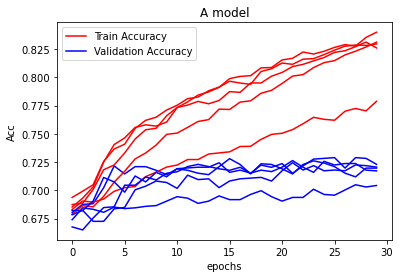

In [17]:
epoch = np.arange(len(lst_train_accuracies[0]))
plt.figure()
for i in range(5):
    plt.plot(epoch, lst_train_accuracies[i], 'r', epoch, lst_val_accuracies[i], 'b')
plt.title("A model")
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('epochs'), plt.ylabel('Acc')
plt.show
#plt.savefig("../plots/FFNN_3_layers_bigthensmall_btchnrm_drpt_bndscr.png", dpi = 400, transparent = False)

In [29]:
N = len(all_data)

def calculate_avg_performance(lst_val_acc, lst_val_lab, lst_val_pred, N):
    """Calculate the generalization error

    Args:
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        N (int): Total number of observations in data set
    """
    avg_recall = 0
    avg_accuracy = 0 
    avg_f1 = 0

    res = np.zeros((5,5))
    for i in range(5):
        best_epoch_model = np.argmax(lst_val_acc[i])
        n = len(lst_val_lab[i][best_epoch_model])
        accuracy = accuracy_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        recall = recall_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        f1 = f1_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])

        res[i][0] = best_epoch_model
        res[i][1] = n
        res[i][2] = accuracy
        res[i][3] = recall
        res[i][4] = f1

        avg_recall += (n/N) * recall
        avg_accuracy += (n/N) * accuracy
        avg_f1 += (n/N) * f1

    print(f"Best average results - Recall: {avg_recall} accuracy: {avg_accuracy} f1-score: {avg_f1}")
    return res

result_mtrx = calculate_avg_performance(lst_val_accuracies, lst_val_labels, lst_val_predictions, N)

Best average results - Recall: 0.6560645413069763 accuracy: 0.7225192332768288 f1-score: 0.7067995647325529


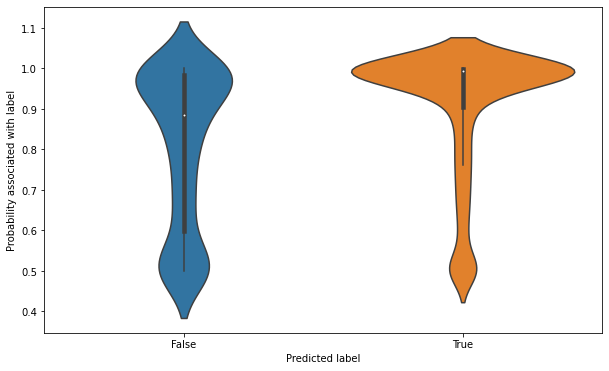

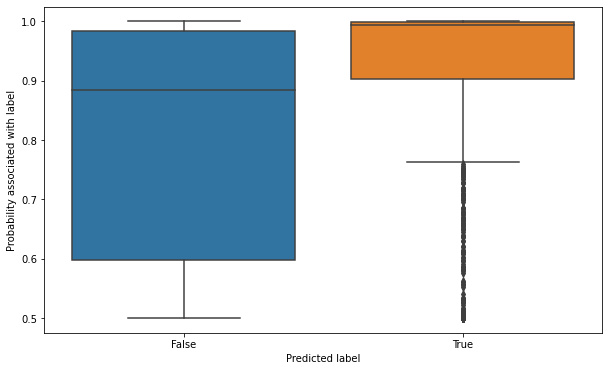

In [35]:
def violin_best_fold(res_mtrx, lst_val_acc, lst_val_lab, lst_val_pred, lst_val_prob):
    """For the best fold, find the best epoch, and plot the violin plot

    Args:
        res_mtrx (matrix): result matrix from calculate_avg_performance
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        lst_val_prob (list of lists): list of lists containing validation probabilities for each fold
    """
    best_fold = np.argmax(res_mtrx[:,2])
    best_epoch_model = np.argmax(lst_val_acc[best_fold])s
    labels_best_epoch = lst_val_lab[best_fold][best_epoch_model]
    predictions_best_epoch = lst_val_pred[best_fold][best_epoch_model]
    probabilities_best_epoch = lst_val_prob[best_fold][best_epoch_model]
    true_predictions = [x==y for x,y in zip(labels_best_epoch,predictions_best_epoch)]
    dataframe = pd.DataFrame()
    dataframe["Probs"] = probabilities_best_epoch
    dataframe["Predictions"] = predictions_best_epoch
    dataframe["Labels"] = labels_best_epoch
    dataframe["True"] = true_predictions    

    plt.figure(figsize=(10,6))
    ax = sns.violinplot(x="True", y="Probs", data=dataframe)
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()

    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x="True", y="Probs", data=dataframe)
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()
        

violin_best_fold(result_mtrx, lst_val_accuracies, lst_val_labels, lst_val_predictions, lst_val_probabilities)